# How to run this file?
In this file, there are three cells: 'define functions', 'simulation', 'graphing' cell. 
- First, run the 'define functions' cell to define functions.
- After you run 'define functions' cell, you will see 'config parameters' section explains the parameters you can change in the next cell ('simulation' cell).
- After you modify parameters, run the 'simulation' cell. You will see '-------Simulation Start----------',..., until'----------Simulation Finished---------', meaning simulation completed. The processing time depends on the game length you select.
- Finally, run the 'graphing' cell. The result shows dynamics graphs over periods. The top left graph shows payoffs for each strategies over periods; The top right graph shows cdf; the bottom graph shows strategies over periods. 

In [1]:
#########################################################
########## run this cell to define functions ############
############### 'define functions' cell #################
#########################################################


########## configuration ############
import math

def sim_config_init(game_type= 'fear', lgr=(10,1.1,0.5), sampling=None, purification_v1=None, purification_v2=None, purification_v3=None,
                    trembling=0., bandwidth=None, 
                    num_bots=20, move_percent = 0.1, game_length=1000, xrange=(2,10), 
                    ):
    '''
    Specify simulation configuration parameters
    :param game_type: string, game type
    :param lgr: tuple, (lambda, gamma, rho), default to (10,1.1,0.5)
    :param sampling: int, number of players to sample (give each player an array of random other players to sample), default to None
    :param purification: idiosyncratic shifts of perceived landscape
    :param trembling: float, trembling range, default to 0, trembles in jump destination
    :param bandwidth: float, smoothing bandwidth, default to None
    :param num_bots: int, number of bots, default to 20
    :param game_length: int, game length, default to 1000
    :param xrange: tuple, strategy range
    :return: config, dictionary containing all simulation configuration parameters
    '''

    config = {}

    # set to -1 to disable
    config['sampling'] = sampling

    # constant e in purification specs
    # set to -1 to disable
    config['purification_v1'] = purification_v1
    
    config['purification_v2'] = purification_v2
    
    config['purification_v3'] = purification_v3

    # trembling range
    # set to 0 to have no effect
    config['trembling'] = trembling


    # smoothing bandwidth
    # set to -1 to disable
    config['bandwidth'] = bandwidth

    # game type
    config['game_type'] = game_type

    # lambda/gamma/rho params
    config['lambda'] = lgr[0]
    config['gamma'] = lgr[1]
    config['rho'] = lgr[2]

    # based on gamma and rho, override game type
    if (config['game_type'] != 'other') and (config['gamma'] >= (config['rho'] + 4/3)):
        config['game_type'] = 'greed'
    elif (config['game_type'] != 'other') and (config['gamma'] <= (config['rho'] + 2/3)):
        config['game_type'] = 'fear'

    # rush range (MUST BE CORRECT IF STARTING AT CDF)
    if config['game_type'] == 'fear':
        config['cdfmin'] = max(0, round((config['lambda'] - math.sqrt(1+config['lambda']**2) * math.sqrt(1-(16*(1+config['rho'])*(config['gamma']-1))/((config['gamma'] +3*config['rho'])*(3*config['gamma'] +config['rho'])))),2))
        config['cdfmax'] = config['lambda']
    elif config['game_type'] == 'greed':
        config['cdfmin'] = config['lambda']
        config['cdfmax'] = config['lambda'] + math.sqrt(1+config['lambda']**2)/(math.sqrt(1+16*config['rho']*config['gamma']/((3*config['gamma']-3*config['rho']-2)*(config['gamma']-config['rho']+2))))

    
    
    # number of bots
    config['num_bots'] = num_bots
    
    # move percentage
    config['move_percent'] = move_percent

    # game length
    config['game_length'] = game_length

    # x bound
    if (config['game_type'] == 'fear') or (config['game_type'] == 'greed'):
        config['xmin'] = max(0 , config['cdfmin']-2)
        config['xmax'] = config['cdfmax'] + 3
    else:
        config['xmin'] = xrange[0]
        config['xmax'] = xrange[1]
        
    

    return config

########## functions ############

import numpy as np
def get_position(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, position for timing n
    '''
    # positions are approximated more accurately by adding 0 to the value for greed and 1 for fear game
    if config['game_type'] == 'fear':
        pos = 1
    elif config['game_type'] == 'greed':
        pos = 0
    else:
        pos = 0.5
    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        if n > strat:
            pos = pos + 1
    return pos

# Returns ties at timing n
# optional parameter seed denotes which set of players to sample (-1 for no sampling)
def get_tie(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    # this is only here to fix rounding comparison issues
    n = round(n,2)

    tie = 0
    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
    # otherwise check all strategies
    else:
        samples = strats
    # compare to strategies to calculate position
    for strat in samples:
        # more rounding stuff due to float precision errors
        strat = round(strat, 2)
        if n == strat:
            tie = tie + 1
    return tie


def get_index(n, seed, strats, sample_sets, config):
    '''

    :param n: float, timing n
    :param seed: index of player i, default to none
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :return: float, ties for timing n
    '''
    # this is only here to fix rounding comparison issues
    n = round(n,2)

    samples = []
    # if using sampling, get the strategies of the sampled players
    if (seed is not None) and (config['sampling'] is not None):
        for samp in sample_sets[seed]:
            samples.append(strats[samp])
        # find the right closest strategy's index
        samples_minus_n = samples - n
        samples_minus_n = np.round(samples - n, 2)
        test_tie_positive = np.any(samples_minus_n>0)
        if (samples_minus_n==0).any() == True:
            sample_index = np.where(samples_minus_n == 0)[0]
            index = []
            for i in sample_index:
                index.append(sample_sets[seed][i])
        elif test_tie_positive == True:
            samples_minus_n_min = min([i for i in samples_minus_n if i > 0])
            sample_index = np.where(samples_minus_n == samples_minus_n_min)[0][0]
            index = sample_sets[seed][sample_index]
        else:
            index = config['sampling']


    # otherwise check all strategies
    else:
        samples = strats
        samples_minus_n = samples - n
        samples_minus_n = np.round(samples - n, 2)
        test_tie_positive = np.any(samples_minus_n>0)
        if (samples_minus_n==0).any() == True:
            index = np.where(samples_minus_n == 0)[0]
        elif test_tie_positive == True:
            samples_minus_n_min = min([i for i in samples_minus_n if i > 0])
            index = np.where(samples_minus_n == samples_minus_n_min)[0][0]
        else:
            index = len(strats)
    


    return index


def get_initial_y(n, strats, sample_sets, config, seed=None, use_bandwidth=False):
    '''

    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    # calculate the timing component
    ux = 1 + (2 * config['lambda'] * n) - (n * n)
    ties = get_tie(n, seed, strats, sample_sets, config)
    pos = get_position(n, seed, strats, sample_sets, config)
    puriVal = 1
    vy = (1 - (pos * puriVal/len(strats))/config['gamma']) * (1 + (pos * puriVal/len(strats)/config['rho']))
    # if there are ties, calculate the average of the position components over the tie range
    if ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((pos+j) * puriVal/len(strats))/config['gamma']) * (1 + ((pos+j) * puriVal/len(strats))/config['rho'])
        vy = vy/ties
    # otherwise just use the regular formula
    if (config['bandwidth'] is not None) and use_bandwidth:
        ux = 0
        start_x = n - config['bandwidth']
        for i in range(21):
            ux += 1 + (2 * config['lambda'] * start_x) - (start_x * start_x)
            start_x += config['bandwidth']/10
        ux = ux/21
    return ux * vy

# Returns the payoff at timing n
def get_y(n, strats, initial_strategies,index, sample_sets, config, seed=None, use_bandwidth=False):
    '''

    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    # calculate the timing component
    if config['purification_v2'] is not None:
        purification_v2 = config['purification_v2']
    else:
        purification_v2 = 0.
    
    if config['purification_v1'] is not None:
        purification_v1 = config['purification_v1']
    else:
        purification_v1 = 0.
        
    num_bots = config['num_bots']
    h = (2 * purification_v1 * index) / (num_bots - 1) - purification_v1
    ux = 1 + (2 * config['lambda'] *(1-h)* n) - (n * n*(1-h)*(1-h))
    
    ties = get_tie(n, seed, strats, sample_sets, config)
    pos = get_position(n, seed, strats, sample_sets, config)
    e = (2 * purification_v2 * index) / (num_bots - 1) - purification_v2
    
    if ties == 0:
        q = pos/len(strats)
        vy = (1 - ((1-e)*q)/config['gamma']) * (1 + ((1-e)*q)/config['rho'])
    # if there are ties, calculate the average of the position components over the tie range
    elif ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((1-e)*(pos+j)/len(strats))/config['gamma']) * (1 + ((1-e)*(pos+j)/len(strats))/config['rho'])
        vy = vy/ties
    # otherwise just use the regular formula
    if (config['bandwidth'] is not None) and use_bandwidth:
        ux = 0
        start_x = n - config['bandwidth']
        for i in range(21):
            ux += 1 + (2 * config['lambda'] * start_x) - (start_x * start_x)
            start_x += config['bandwidth']/10
        ux = ux/21
    if config['purification_v3'] is not None:
        purification_v3 = config['purification_v3']
        gx = 1+ max(0, round(purification_v3-abs(n-initial_strategies[index]),2))
    else:
        gx = 1
#     print('pos is {}'.format(pos))
#     print('index is {}'.format(index))
#     print('e is {}'.format(e))
#     print('vy is {}'.format(vy))
#     print('ux is {}'.format(ux))
    return ux * vy * gx

# Returns the payoff at timing n
def stategies_get_y(n, strats,index, sample_sets, config, seed=None, use_bandwidth=False):
    '''

    :param n: float, timing n
    :param strats: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :param config: dict, dictionary containing simulation parameters
    :param seed: index of player i, default to none
    :param use_bandwidth:
    :return: float, payoff
    '''
    # calculate the timing component
    num_bots = config['num_bots']

    ux = 1 + (2 * config['lambda'] * n) - (n * n)
    ties = get_tie(n, seed, strats, sample_sets, config)
    pos = get_position(n, seed, strats, sample_sets, config)
    if ties == 0:
        q = pos/len(strats)
        vy = (1 - q/config['gamma']) * (1 + q/config['rho'])
    # if there are ties, calculate the average of the position components over the tie range
    elif ties > 0:
        vy = 0
        for j in range(ties):
            vy += (1 - ((pos+j)/len(strats))/config['gamma']) * (1 + ((pos+j)/len(strats))/config['rho'])
        vy = vy/ties
    # otherwise just use the regular formula
    if (config['bandwidth'] is not None) and use_bandwidth:
        ux = 0
        start_x = n - config['bandwidth']
        for i in range(21):
            ux += 1 + (2 * config['lambda'] * start_x) - (start_x * start_x)
            start_x += config['bandwidth']/10
        ux = ux/21

#     print('pos is {}'.format(pos))
#     print('index is {}'.format(index))
#     print('e is {}'.format(e))
#     print('vy is {}'.format(vy))
#     print('ux is {}'.format(ux))
    return ux * vy

def data_logging(var_name_list, round_num, history):
    for var in var_name_list:
        history[var, round_num] = eval({var})

    return history


########## simulation functions ############
import random
import numpy as np
# from timing_games_package import Functions as fun

def initialize_player_strategies(config):
    '''
    Function to run first simulation step to initialize each player's initial strategy
    :param config: dict, dictionary contains simulation parameters
    :return: array, initial strategies;  ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    '''
    # game type for starting distribution: set to fear or greed for respective distributions
    # any value other than fear or greed will yield a random start
    game = config['game_type']
    num_bots = config['num_bots']
    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    sampling = config['sampling']
    xmin = config['xmin']
    xmax = config['xmax']

    strategies = []
    sample_sets = []

    # set initial strategies and sampling
    # these calculations are inexact because we have a finite number of players
    # greed, fear, and random starting distributions have differing calculations
    if game == "fear":
        cdfx = np.round(np.arange(config['cdfmin'], config['cdfmax'], 0.01), 2)
        cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = 0
        cdfy = cdfy/2
        for i in range(num_bots):
            # y_ind is the index in the cdf to compare to
            # we increment it until it is greater than or equal to the percentage of players set so far
            if (i+1)/num_bots <= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind < len(cdfy) - 1 and (i+1)/num_bots > cdfy[y_ind]:
                    y_ind = y_ind + 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind >= len(cdfy):
                    strategies.append(cdfx[len(cdfy)])
                else:
                    strategies.append(cdfx[y_ind])

    elif game == "greed":
        cdfx = np.round(np.arange(config['cdfmin'], config['cdfmax'], 0.01), 2)
        cdfy = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2) / (1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = len(cdfy) - 1
        cdfy = cdfy / 2

        i = num_bots
        while i > 0:
            # y_ind is the index in the cdf to compare to
            # we decrement it until it is less than or equal to the percentage of players set so far
            if (i-1)/num_bots >= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind > 0 and (i-1)/num_bots < cdfy[y_ind]:
                    y_ind = y_ind - 1
                # there are some rounding issues when we reach the end of the cdf
                # if we reach the end (for the last few players), just use the last value
                if y_ind == 0:
                    strategies.append(cdfx[0])
                else:
                    strategies.append(cdfx[y_ind])
            i = i - 1
    else:
        for i in range(num_bots):
            strategies.append(random.random() * (xmax - xmin) + xmin)

    strategies = np.round(np.array(strategies), 2)
    strategies = np.sort(strategies)

    # apply sampling
    for i in range(num_bots):
        if sampling is not None:
            other_player_index_list = list(range(num_bots))
            other_player_index_list.remove(i)
            to_add = random.sample(other_player_index_list, sampling)
            sample_sets.append(to_add)
            
    initial_strategies = strategies

    return strategies, sample_sets, initial_strategies

def calculate_initial_payoff(config, strategies, sample_sets):
    '''

    :param config: dict, dictionary contains simulation parameters
    :param strategies: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :return: x: array of possible x; y: array of payoff given timing x; strat_x: sorted strategies from low to high;
             strat_y: array of payoffs given sorted strategies; strategies_y: array of payoffs given strategies
    '''

    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    xmin = config['xmin']
    xmax = config['xmax']
    # set the array of possible x values
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    positions = []
    ties = []
    # set up initial values for landscape positions and ties
    for val in x:
        positions.append(get_position(val, None, strategies, sample_sets, config))
        ties.append(get_tie(val, None, strategies, sample_sets, config))
    positions = np.array(positions)
    # calculate timing component
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    quantile = []
    # calculate positional component, including ties
    for i in range(len(positions)):
        if ties[i] == 0:
            vy.append((1 - (positions[i]/len(strategies))/gam) * (1 + (positions[i]/len(strategies))/rho))
            quantile.append(positions[i]/len(strategies))
        else:
            total = 0
            total_quantile = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
                total_quantile += (positions[i])/len(strategies)
            total = total/ties[i]
            vy.append(total)
            total_quantile = total_quantile/ties[i]
            quantile.append(total_quantile)
            
    quantile = np.array(quantile)
    if config['game_type'] == 'fear':
        quantile = quantile - 1/config['num_bots']
    elif config['game_type'] == 'other':
        quantile = quantile - 0.5/config['num_bots']    
        
    y = ux * vy
    strategies_y = []
    # calculate bubble positions
    for strat in strategies:
        strategies_y.append(get_initial_y(strat, strategies, sample_sets, config, seed=None, use_bandwidth=False))
    bubble = strategies_y
    return x, y, strategies_y, quantile, bubble

def calculate_payoff(config, static_strategies, strategies, sample_sets):
    '''

    :param config: dict, dictionary contains simulation parameters
    :param strategies: array, current strategies
    :param sample_sets: ndarray, sample sets (None if sampling is none), give each player an array of random other players to sample
    :return: x: array of possible x; y: array of payoff given timing x; strat_x: sorted strategies from low to high;
             strat_y: array of payoffs given sorted strategies; strategies_y: array of payoffs given strategies
    '''

    lam = config['lambda']
    gam = config['gamma']
    rho = config['rho']
    xmin = config['xmin']
    xmax = config['xmax']
    num_bots = config['num_bots']
    
        
    # set the array of possible x values
    x = np.round(np.arange(xmin, xmax, 0.01),2)
    positions = []
    ties = []
    index = []

    # set up initial values for landscape positions and ties
    for val in x:
        positions.append(get_position(val, None, strategies, sample_sets, config))
        ties.append(get_tie(val, None, strategies, sample_sets, config))
    positions = np.array(positions)
    # calculate timing component
    ux = 1 + (2 * lam * x) - (x * x)
    vy = []
    quantile = []
    # calculate positional component, including ties
    for i in range(len(positions)):
        if ties[i] == 0:
            q = positions[i]/len(strategies)
            vy.append((1 - q/gam) * (1 + q/rho))
            quantile.append(q)
        else:
            total = 0
            total_quantile = 0
            for j in range(ties[i]):
                total += (1 - ((positions[i]+j)/len(strategies))/gam) * (1 + ((positions[i]+j)/len(strategies))/rho)
                total_quantile += (positions[i])/len(strategies)
            total = total/ties[i]
            vy.append(total)
            total_quantile = total_quantile/ties[i]
            quantile.append(total_quantile)
        
    quantile = np.array(quantile)
    if config['game_type'] == 'fear':
        quantile = quantile - 1/config['num_bots']
    elif config['game_type'] == 'other':
        quantile = quantile - 0.5/config['num_bots']
        
            
    y = ux * vy
    
    strategies_y = []
    bubble = []
    # calculate bubble positions
    
    for index,strat in enumerate(strategies):
        strategies_y.append(get_y(strat, strategies, initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=False))
    for bub in strategies:
        bubble.append(stategies_get_y(bub, strategies, index, sample_sets, config, seed=None, use_bandwidth=False))
    return x, y, strategies_y, quantile, bubble

# Loops through all players and moves them if they are ready to move
def update_player_strategies(x, y, strategies, strategies_y, initial_strategies, sample_sets, config):
    '''

    :param x: numpy array, array of possible x
    :param y: numpy array, payoff array w.r.t each element in x
    :param strategies: list, list containing previous strategies of each player
    :param config: dict, dictionary containing simulation parameters
    :return: strategies: list, list containing updated strategies of each player
    '''

    trembling = config['trembling']
    move_size = round(config['move_percent'] *config['num_bots'])

    best_possible = max(y)

    # jump frequencies proportional to regret
    distances_from_best_payoff = abs(strategies_y-best_possible)
    players_index = list(range(len(strategies)))
    selected_player_index = random.choices(players_index, weights=distances_from_best_payoff,k=move_size)
    selected_player_index = set(selected_player_index)
    if len(selected_player_index) != move_size:
        remaining_player_index = set(players_index) - selected_player_index
        remaining_selected_index = random.sample(remaining_player_index,k=move_size-len(selected_player_index))
        selected_player_index.update(remaining_selected_index)

    static_strategies = strategies.copy()
    for i in selected_player_index:
    # find best payoff index
        index = i
        if config['sampling'] is not None:
            y1 = []
            for val in x:
                y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=i, use_bandwidth=True))
            best = max(y1)
            # if there are multiple timings with the best payoff, choose randomly
            indices = [k for k, j in enumerate(y1) if j == best]
            best_choice = random.choice(indices)
            best_choice = x[best_choice]   
            
        elif config['purification_v1'] is not None:
            y1 = []
            for val in x:
                y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=True))
            best = max(y1)
            # if there are multiple timings with the best payoff, choose randomly
            indices = [k for k, j in enumerate(y1) if j == best]
            best_choice = random.choice(indices)
            best_choice = x[best_choice]
            
        elif config['purification_v2'] is not None:
            y1 = []
            for val in x:
                y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=True))
            best = max(y1)
            # if there are multiple timings with the best payoff, choose randomly
            indices = [k for k, j in enumerate(y1) if j == best]
            best_choice = random.choice(indices)
            best_choice = x[best_choice]
        
        elif config['purification_v3'] is not None:
            y1 = []
            for val in x:
                y1.append(get_y(val, static_strategies,initial_strategies, index, sample_sets, config, seed=None, use_bandwidth=True))
            best = max(y1)
            # if there are multiple timings with the best payoff, choose randomly
            indices = [k for k, j in enumerate(y1) if j == best]
            best_choice = random.choice(indices)
            best_choice = x[best_choice]            
            
        else:
            indices = [k for k, j in enumerate(y) if j == best_possible]
            best_choice = random.choice(indices)
            best_choice = x[best_choice]                

        strategies[i] = best_choice + round((random.random() * trembling - trembling/2), 2)


    return static_strategies, strategies, selected_player_index


# from timing_games_package import Simulation
# from timing_games_package.Configuration import sim_config_init
import matplotlib.pyplot as plt
# import matplotlib.animation as animation
from matplotlib import style
import numpy as np
import pandas as pd
plt.style.use('default')

# config parameters (you can change values in the cell below)

`game_type`: game type. It could be 'fear' or 'greed', or 'other'.
- `game_type` is optional for only fear or only greed game. For example, if you specify `game_type='greed'` while $\gamma \leq \rho + 2/3$, the code will override game type you specified and force it to 'fear' instead.
- If you choose 'other', the initial strategies will be selected based on uniform distribution. You need to specify the range `xrange`.

`lgr`: lambda/gamma/rho params: (lambda, gamma, rho)
- `lgr=(10,1.1,0.5)` means (lambda, gamma, rho)=(10, 1.1, 0.5)

||game type|
|--|--|
|$\gamma \leq \rho + 2/3$|only fear game|
|$\rho + 2/3 < \gamma < \rho + 4/3 $|fear or greed equilibrium|
|$\gamma \geq \rho + 4/3 $|only greed|


`sampling`: number of players to sample. Give each player an array of random other players to sample, default to None.
- `sampling=None` means players could observe all other players' moves.
- `sampling=5` means players could only observe 5 other players' moves.

`purification`: idiosyncratic shifts of perceived landscape. It could be 0.1, 0.2 etc.
- u(x)v((1-e)q), with e=2di/(N-1)-d for i=0,...N-1 when num_bots=N. Specifically, d=purification.
- `purification=None` meaning purification is disabled.


`trembling`: trembling range (set to 0 to have no effect. It could be 0.1, 0.2, etc

`bandwidth`: smoothing bandwidth (set None to disable). It could be 0.1, 0.2, etc


`num_bots`: number of bots

`move_percent`: the percent of players that move each period. It could be 0.1, 0.2, etc.
- fully asynchronous if `move_percent=1/number of bots` (meaning only one player moves per period)
- fully synchronous if `move_percent=1.0` (meaning all players move per period)

Example: if `num_bots=20` and `move_percent=0.05`, we have fully asynchronicity; if `num_bots=20` and `move_percent=1.0`, we have fully synchronicity.


`game_length`: game length. Simulation periods

`xrange`: you need to specify x range if the game type is 'other'.



# selected parameters based on theory

|$\lambda$|$\gamma$|$\rho$|game type|rush size|rush time|slow play on|Nah payoff|
|--|--|--|--|--|--|--|--|
|10|1.1|0.5| only fear|q0=0.45|1.26|[1.26,10]| 27.545| 
|10|1.5|0.5| fear equilibrium|q0=0.75|5.51|[5.51,10]| 100.90|
|10|1.5|0.5| greed equilibrium|q1=0.25|14.49|[10,14.49]| 101|
|10|2|0.5| only greed|q1=0.725|15.97|[10,15.97]| 101|
|10|2.5|2| only fear|q0=0.375|6.69|[6.69,10]| 90.9| 
|10|2.5|1.7| fear equilibrium|q0=0.6|7.28|[7.28,10]| 96.2|
|10|2.5|1.7| greed equilibrium|q1=0.1|11.27|[10,11.27]| 101|
|10|2.5|1.3| fear equilibrium|q0=0.9|8.58|[8.58,10]| 107.2|
|10|2.5|1.3| greed equilibrium|q1=0.4|13|[10,13]| 101|
|10|2.5|1| only greed|q1=0.625|14.25|[10,14.25]| 101|
|10|3|2| fear equilibrium|q0=0.75|8.25|[8.25,10]| 101|
|10|3|2| greed equilibrium|q1=0.25|11.74|[10,11.74]| 101|
|10|3.6|2| only greed|q1=0.7|12.85|[10,12.85]| 101|


This is only greed game
----------------Simulation Start----------------
Period 0 done
Period 20 done
Period 40 done
Period 60 done
Period 80 done
Period 100 done
Period 120 done
Period 140 done
Period 160 done
Period 180 done
Period 200 done
Period 220 done
Period 240 done
Period 260 done
Period 280 done
Period 300 done
Period 320 done
Period 340 done
Period 360 done
Period 380 done
Period 400 done
Period 420 done
Period 440 done
Period 460 done
Period 480 done
Period 500 done
Period 520 done
Period 540 done
Period 560 done
Period 580 done
Period 600 done
----------------Simulation Finished----------------
The initial strategies are [10.   10.14 10.21 10.25 10.29 10.33 10.36 10.39 10.42 10.44 10.47 10.49
 10.51 10.53 10.55 10.57 10.59 10.61 10.63 10.64 10.66 10.68 10.69 10.71
 10.72 10.74 10.75 10.76 10.78 10.79 10.81 10.82 10.83 10.84 10.86 10.87
 10.88 10.89 10.9  10.92 10.93 10.94 10.95 10.96 10.97 10.98 10.99 11.
 11.01 11.02 11.03 11.04 11.05 11.06 11.07 11.08 11.09 11.1  11.11 1

The second period strategies are [10.   10.14 10.21 10.25 10.29 10.33 10.36 10.39 10.42 10.44 10.47 10.49
 10.51 10.53 10.55 12.42 10.59 10.61 10.63 10.64 10.66 10.68 10.69 10.71
 10.72 10.74 10.75 10.76 10.78 10.79 10.81 10.82 10.83 10.84 10.86 10.87
 10.88 10.89 10.9  10.92 10.93 10.94 10.95 10.96 12.51 10.98 10.99 11.
 11.01 11.02 11.03 11.04 11.05 11.06 11.07 11.08 11.09 11.1  11.11 11.12
 11.13 11.14 11.14 11.15 11.16 11.17 11.18 11.19 11.2  11.2  11.21 11.22
 11.23 11.24 11.24 11.25 11.26 11.27 11.27 11.28 11.29 11.3  11.31 11.31
 11.32 11.33 11.33 11.34 11.35 11.36 11.36 11.37 11.38 11.38 11.39 11.4
 11.4  11.41 11.42 11.42 11.43 11.44 11.44 11.45 11.46 11.46 11.47 11.48
 11.48 11.49 11.49 11.5  11.51 11.51 11.52 11.52 11.53 11.54 11.54 11.55
 11.55 11.56 11.57 11.57 11.58 11.58 11.59 11.59 11.6  11.61 11.61 11.62
 11.62 11.63 11.63 11.64 11.64 11.65 11.65 11.66 11.66 11.67 11.68 11.68
 11.69 11.69 11.7  11.7  11.71 11.71 11.72 11.72 11.73 11.73 11.74 11.74
 11.75 11.75 11.76 11

<IPython.core.display.Javascript object>


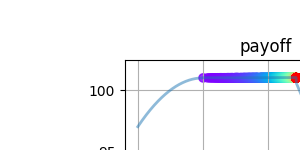

The "1" meaning the first 20% bots with the smaller index,...
For example, if we have 20 bots, "1" means the players with index from 0 to 4;"2" means the players with index from 5 to 9


In [6]:
####################################################################################
########## run this cell to run simulation after you change parameters ############
############################### 'simulation' cell #################################
####################################################################################
from datetime import datetime
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt

start=datetime.now()

history = {}
round_idx = 0

# Set up simulation configuration
#####################################
### you can change parameters here ###
#####################################
sim_config = sim_config_init(
    game_type='greed',
    lgr=(10,3.6,2),
    sampling=None, 
    purification_v1=None, 
    purification_v2=0.1, 
    purification_v3=None,
    trembling=0.2, 
    bandwidth=None,
    num_bots=1000,
    move_percent=0.02,
    game_length=600,
    xrange=(0,12),
)



# Simulate players' initial strategies and payoffs
strategies, sample_sets, initial_strategies = initialize_player_strategies(sim_config)
x, y, strategies_y, quantile, bubble = calculate_initial_payoff(sim_config, strategies, sample_sets)

# Log data for the initial round
# history = data_logging(['strategies', 'x', 'y', 'strat_x', 'strat_y'], round_idx, history) # To Do
history['strategies', round_idx] = strategies.copy()
history['x', round_idx] = x
history['y', round_idx] = y
history['strategies_y', round_idx] = strategies_y
history['quantile', round_idx] = quantile
history['selected_player_index', round_idx] = None
history['bubble', round_idx] = bubble

# Iterate simulation to update players' strategies and payoff
max_game_length = sim_config['game_length']

if sim_config['game_type'] == 'other':
    game_type_specification = sim_config['game_type']
elif (sim_config['gamma'] <= sim_config['rho'] + 2/3) or (sim_config['gamma'] >= sim_config['rho'] + 4/3):
    game_type_specification = 'only ' + sim_config['game_type']
else:
    game_type_specification = sim_config['game_type'] + ' equilibrium'    
print('This is {} game'.format(game_type_specification))
print('----------------Simulation Start----------------')
print('Period 0 done')
while round_idx < max_game_length:
    round_idx += 1
    static_strategies, strategies, selected_player_index = update_player_strategies(x, y, strategies,strategies_y,initial_strategies, sample_sets, sim_config)
    x, y, strategies_y, quantile, bubble = calculate_payoff(sim_config, static_strategies, strategies, sample_sets)

    # Log data for the round
    history['strategies', round_idx] = strategies.copy()
    history['x', round_idx] = x
    history['y', round_idx] = y
    history['strategies_y', round_idx] = strategies_y
    history['quantile', round_idx] = quantile
    history['selected_player_index', round_idx] = selected_player_index
    history['bubble', round_idx] = bubble
    if round_idx%20 == 0:
        print('Period {} done'.format(round_idx))
    
print('----------------Simulation Finished----------------')

print('The initial strategies are {}'.format(history['strategies', 0]))
print('The initial unpurified payoffs are {}'.format(history['bubble', 0]))
print('The initial purified payoffs are {}'.format(history['strategies_y', 0]))

print('The second period strategies are {}'.format(history['strategies', 1]))
print('The second period unpurified payoffs are {}'.format(history['bubble', 1]))
print('The second period purified payoffs are {}'.format(history['strategies_y', 1]))

print('simulation spent time: {}'.format(datetime.now()-start))



#assign colors to 20%, 40%, 60%, 80%, 100% players
color_list = ['r','g','black','y','blue']
first_20_percent = round(sim_config['num_bots']*0.2)
first_40_percent = round(sim_config['num_bots']*0.4)
first_60_percent = round(sim_config['num_bots']*0.6)
first_80_percent = round(sim_config['num_bots']*0.8)
first_100_percent = round(sim_config['num_bots']*1)

#theoritical cdf if starting with Nash
if sim_config['game_type'] != 'other':
    game = sim_config['game_type']
    lam = sim_config['lambda']
    gam = sim_config['gamma']
    rho = sim_config['rho']
    cdfmin = sim_config['cdfmin']
    cdfmax = sim_config['cdfmax']
    xmin = sim_config['xmin']
    xmax = sim_config['xmax']
    num_bots =10000
    strategies = []

    if game == "fear":
        cdfx = np.round(np.arange(cdfmin, cdfmax, 0.01), 2)
        cdfy = gam - rho + np.sqrt((gam + rho) ** 2 - 4 * ((1 + rho) * (gam - 1) * (1 + lam ** 2))/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = 0
        cdfy = cdfy/2
        for i in range(num_bots):
            if (i+1)/num_bots <= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind < len(cdfy) - 1 and (i+1)/num_bots > cdfy[y_ind]:
                    y_ind = y_ind + 1
                if y_ind >= len(cdfy):
                    strategies.append(cdfx[len(cdfy)])
                else:
                    strategies.append(cdfx[y_ind])

    elif game == "greed":
        cdfx = np.round(np.arange(cdfmin, cdfmax, 0.01), 2)
        cdfy = gam - rho - np.sqrt((gam + rho) ** 2 - 4 * gam * rho * (1 + lam ** 2)/(1 + 2 * lam * cdfx - cdfx ** 2))
        y_ind = len(cdfy) - 1
        cdfy = cdfy/2
        i = num_bots
        while i > 0:
            if (i-1)/num_bots >= cdfy[y_ind]:
                strategies.append(cdfx[y_ind])
            else:
                while y_ind > 0 and (i-1)/num_bots < cdfy[y_ind]:
                    y_ind = y_ind - 1
                if y_ind == 0:
                    strategies.append(cdfx[0])
                else:
                    strategies.append(cdfx[y_ind])
            i = i - 1

    else:
        for i in range(num_bots):
            strategies.append(random.random() * (xmax - xmin) + xmin)

    strategies_cdf = np.round(np.array(strategies), 2)
    strategies_cdf.sort()
    strategies_cdf = np.insert(strategies_cdf,0,xmin)
    strategies_cdf = np.append(strategies_cdf,xmax)
    pdf = np.array([1/num_bots]*num_bots)
    cdf=np.cumsum(pdf)
    cdf = np.insert(cdf,0,0)
    cdf = np.append(cdf,1)


    fig = plt.figure(figsize=(10,5))
    gs = fig.add_gridspec(1, 2)
    ax1 = fig.add_subplot(gs[0, 0])
    ax2 = fig.add_subplot(gs[0, 1])
    plt.ion()



    ax1.plot(history['x', 0], history['y', 0], alpha=0.5, linewidth = '2')
#     ax1.scatter(history['strategies', 0][:first_20_percent], history['strategies_y', 0][:first_20_percent], alpha = 0.5,label='0-20%', marker='$1$', color='black')
#     ax1.scatter(history['strategies', 0][first_20_percent:first_40_percent], history['strategies_y', 0][first_20_percent:first_40_percent], label='20-40%', marker='$2$', color='r')
#     ax1.scatter(history['strategies', 0][first_40_percent:first_60_percent], history['strategies_y', 0][first_40_percent:first_60_percent], label='40-60%', marker='$3$', color='g')
#     ax1.scatter(history['strategies', 0][first_60_percent:first_80_percent], history['strategies_y', 0][first_60_percent:first_80_percent], label='60-80%', marker='$4$', color='b')
#     ax1.scatter(history['strategies', 0][first_80_percent:first_100_percent], history['strategies_y', 0][first_80_percent:first_100_percent], label='80-100%', marker='$5$', color='y')
    graph = ax1.scatter(history['strategies', 0], history['strategies_y', 0],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.8)

    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
#     ax1.legend()
    fig.colorbar(graph, ax=ax1)

    ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
    ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
    ax2.set_xlabel('time x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid()
    ax2.legend()

    fig.suptitle(game_type_specification + ' game: Period 0')
    fig.canvas.draw()
    
    output_name = sim_config['game_type'] + '__lgr_' + str(sim_config['lambda'])+'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'__' + 'bots_' + str(sim_config['num_bots']) + '__length_' + str(sim_config['game_length'])
    fig.savefig(output_name + '.png', dpi=fig.dpi, bbox_inches='tight')
    
    print('The "1" meaning the first 20% bots with the smaller index,...')
    print('For example, if we have 20 bots, "1" means the players with index from 0 to 4;"2" means the players with index from 5 to 9' )


<IPython.core.display.Javascript object>


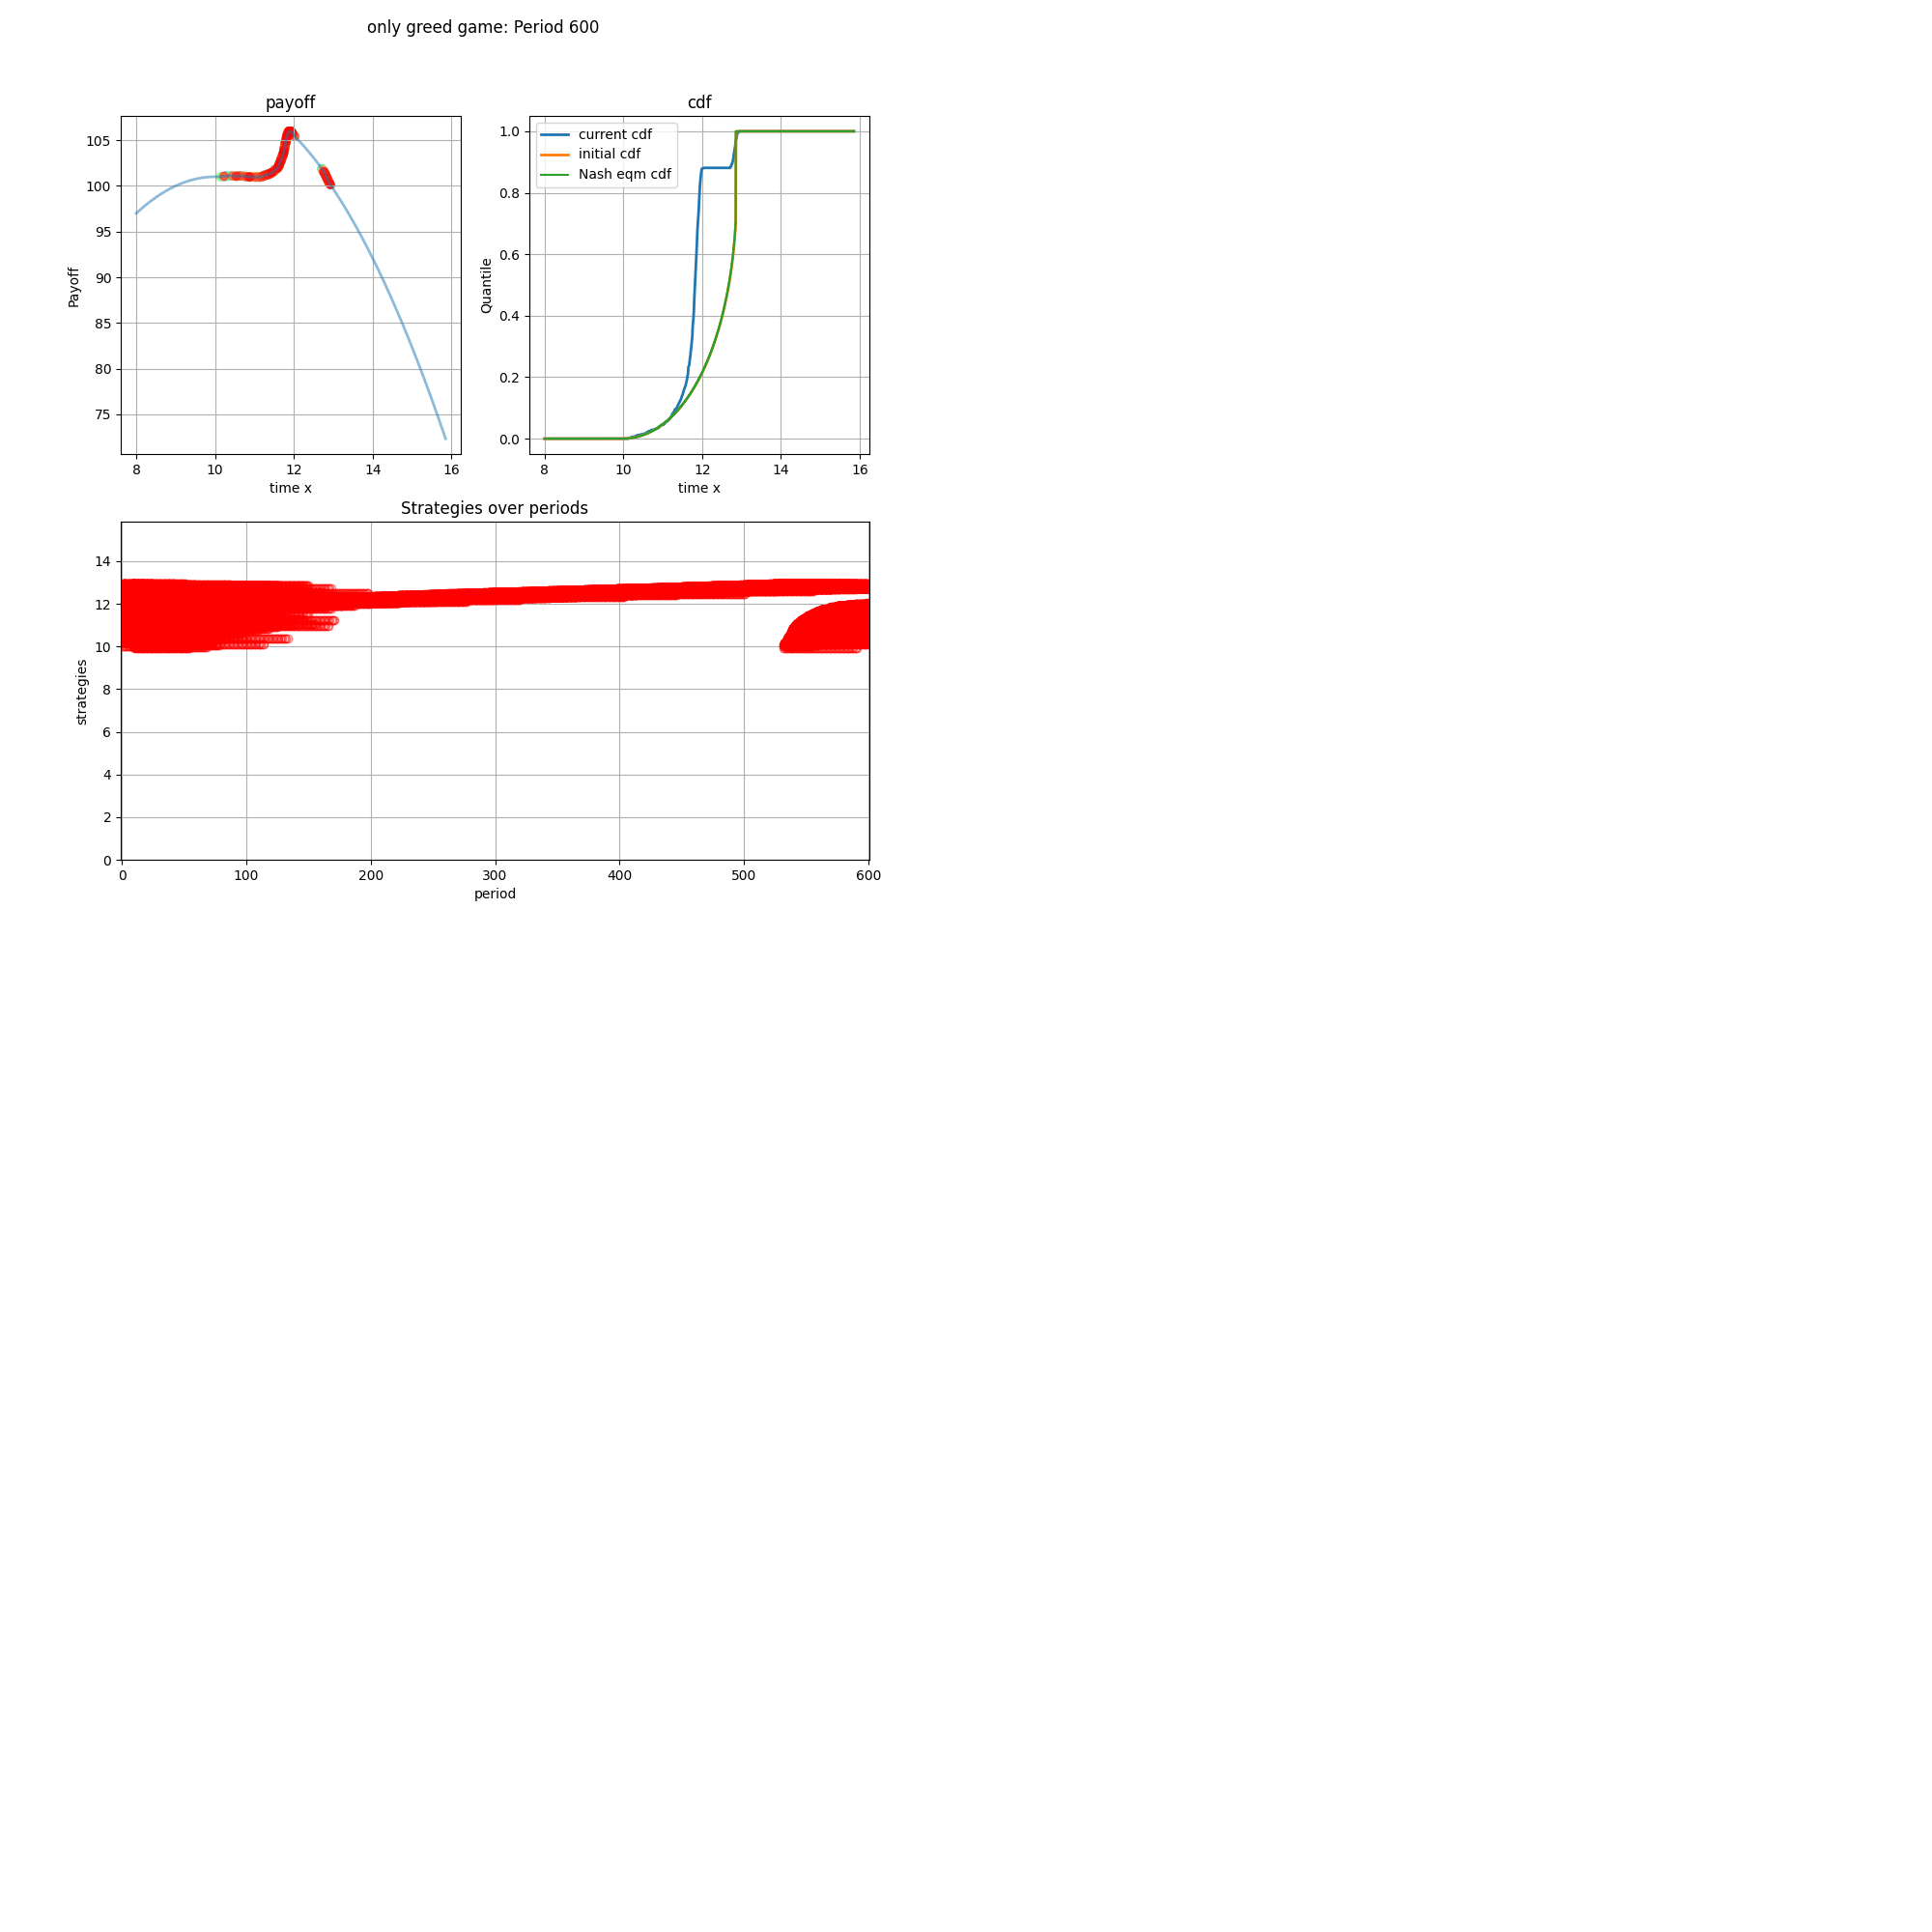

Done


In [7]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################

%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt


fig = plt.figure(figsize=(10,10))
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
plt.ion()

fig.show()
fig.canvas.draw()

for i in range(round_idx+1):
    ax1.clear()
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2')
#     ax1.scatter(history['strategies', i][:first_20_percent], history['strategies_y', i][:first_20_percent],label='0-20%', marker='$1$', color='black')
#     ax1.scatter(history['strategies', i][first_20_percent:first_40_percent], history['strategies_y', i][first_20_percent:first_40_percent],label='20-40%', marker='$2$', color='r')
#     ax1.scatter(history['strategies', i][first_40_percent:first_60_percent], history['strategies_y', i][first_40_percent:first_60_percent],label='40-60%', marker='$3$', color='g')
#     ax1.scatter(history['strategies', i][first_60_percent:first_80_percent], history['strategies_y', i][first_60_percent:first_80_percent],label='60-80%', marker='$4$', color='b')
#     ax1.scatter(history['strategies', i][first_80_percent:first_100_percent], history['strategies_y', i][first_80_percent:first_100_percent],label='80-100%', marker='$5$', color='y')

    graph = ax1.scatter(history['strategies', i], history['bubble', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.6)
    
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
#     ax1.legend()

    if sim_config['game_type'] != 'other': 
        ax2.clear()
        ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf')
        ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf')
        ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf')
        ax2.set_xlabel('time x')
        ax2.set_ylabel('Quantile')
        ax2.set_title('cdf')
        ax2.grid()
        ax2.legend()
    else:
        ax2.clear()
        ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf')
        ax2.set_xlabel('time x')
        ax2.set_ylabel('Quantile')
        ax2.set_title('cdf')
        ax2.grid()
        ax2.legend()
    
    plot_round = np.array([i]*len(history['strategies', 0]))
    ax3.plot(plot_round, history['strategies', i], 'ro', fillstyle='none', alpha=0.5)
    ax3.set_xlim([-1, round_idx+1])
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()
    
    
    plt.pause(0.001)
    fig.suptitle(game_type_specification + ' game: Period ' + str(i))
    fig.canvas.draw()
output_name = sim_config['game_type'] + '__lgr_' + str(sim_config['lambda'])+'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'__' + 'bots_' + str(sim_config['num_bots']) + '__length_' + str(sim_config['game_length'])
fig.savefig(output_name + '_end.png', dpi=fig.dpi, bbox_inches='tight')

print('Done')

The "1" meaning the first 20% bots with the smaller index,...


For example, if we have 20 bots, "1" means the players with index from 0 to 4;"2" means the players with index from 5 to 9


<IPython.core.display.Javascript object>


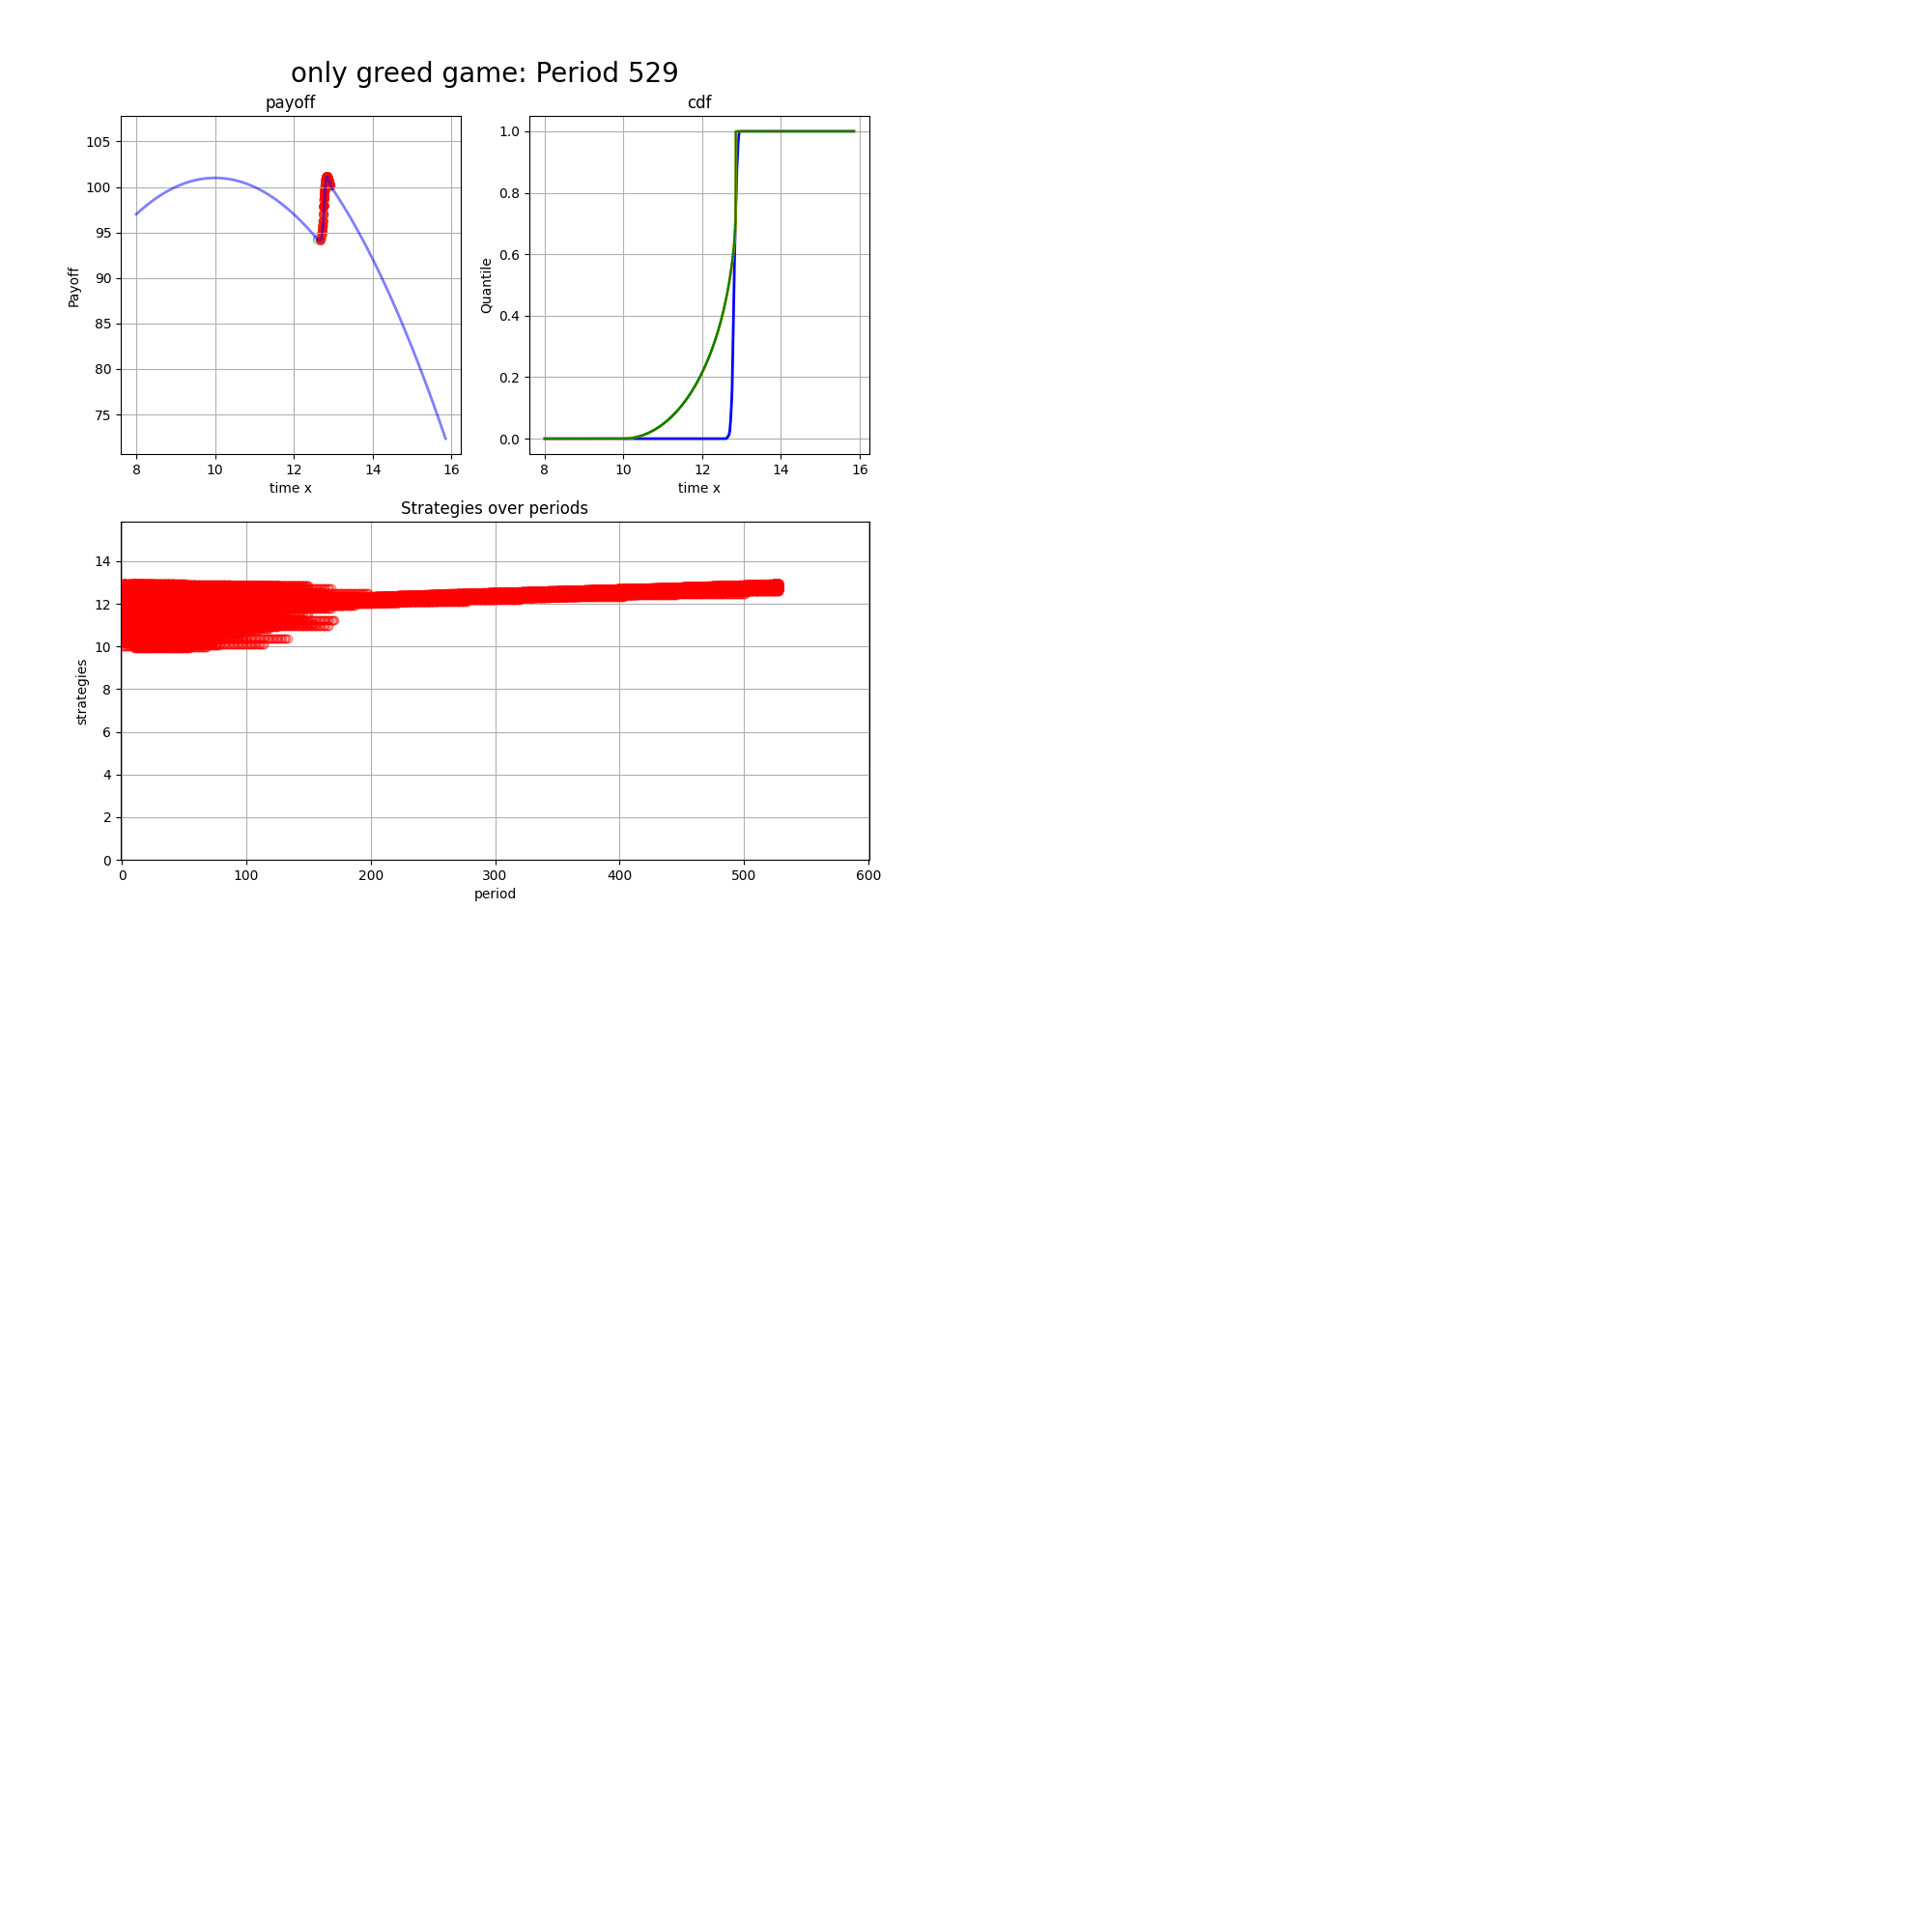

MovieWriter ffmpeg unavailable; using Pillow instead.


Done


In [8]:
####################################################################################
########## after finishing simulation, run this cell to make graphs ############
############################### 'graphing' cell #################################
####################################################################################


import numpy as np
import matplotlib.pyplot as plt
from celluloid import Camera

fig = plt.figure(figsize=(10,10))
camera = Camera(fig)
gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, :])
plt.ion()

# fig.show()
# fig.canvas.draw()

for i in range(round_idx+1):
#     ax1.clear()
    ax1.plot(history['x', i], history['y', i], alpha=0.5, linewidth = '2', c='b')
    graph = ax1.scatter(history['strategies', i], history['bubble', i],c = list(range(0,sim_config['num_bots'])), cmap='rainbow', alpha=0.6)

#     ax1.scatter(history['strategies', i][:first_20_percent], history['strategies_y', i][:first_20_percent],label='0-20%', marker='$1$', color='black')
#     ax1.scatter(history['strategies', i][first_20_percent:first_40_percent], history['strategies_y', i][first_20_percent:first_40_percent],label='20-40%', marker='$2$', color='r')
#     ax1.scatter(history['strategies', i][first_40_percent:first_60_percent], history['strategies_y', i][first_40_percent:first_60_percent],label='40-60%', marker='$3$', color='g')
#     ax1.scatter(history['strategies', i][first_60_percent:first_80_percent], history['strategies_y', i][first_60_percent:first_80_percent],label='60-80%', marker='$4$', color='b')
#     ax1.scatter(history['strategies', i][first_80_percent:first_100_percent], history['strategies_y', i][first_80_percent:first_100_percent],label='80-100%', marker='$5$', color='y')
#     if history['selected_player_index', i] is not None:
#         ax1.plot(history['strategies', i][history['selected_player_index', i]], 
#              history['strategies_y', i][history['selected_player_index', i]], 'bs', fillstyle='none')
#     if (history['selected_player_index', i] is not None) and (i>0):
#         ax1.plot(history['strategies', i-1][history['selected_player_index', i]], 
#          history['strategies_y', i-1][history['selected_player_index', i]], 'gv', fillstyle='none', label='who gets the chance to move')
#     ax1.set_ylim([0, sim_config['lambda']**2+100])
    ax1.set_xlabel('time x')
    ax1.set_ylabel('Payoff')
    ax1.set_title('payoff')
    ax1.grid()
#     fig.colorbar(graph, ax=ax1)
#     ax1.legend()
    
#     ax2.clear()
    ax2.plot(history['x', i], history['quantile', i], linewidth = '2', label='current cdf', c='b')
    ax2.plot(history['x', 0], history['quantile', 0], linewidth = '2', label='initial cdf', c='orange')
    ax2.plot(strategies_cdf, cdf, label='Nash eqm cdf', c='g')
    ax2.set_xlabel('time x')
    ax2.set_ylabel('Quantile')
    ax2.set_title('cdf')
    ax2.grid()
#     ax2.legend()
    
    for rd in range(i):
        plot_round = np.array([rd]*len(history['strategies', 0])) 
        ax3.plot(plot_round, history['strategies', rd], 'ro', fillstyle='none', alpha=0.5)
#     if history['selected_player_index', i] is not None:
#         ax3.plot(i, history['strategies', i][history['selected_player_index', i]], 'bs', fillstyle='none')
#     if (history['selected_player_index', i] is not None) and (i>0):
#         ax3.plot(i, history['strategies', i-1][history['selected_player_index', i]], 'gv', fillstyle='none')
    ax3.set_xlim([-1, round_idx+1])
    ax3.set_ylim([0, sim_config['xmax']])
    ax3.set_xlabel('period')
    ax3.set_ylabel('strategies')
    ax3.set_title('Strategies over periods')
    ax3.grid()
    
    
    plt.pause(0.001)
    ax1.text(0.5, 1.1, game_type_specification + ' game: Period ' + str(i), transform=ax1.transAxes,fontsize = 20)
#     fig.suptitle(game_type_specification + ' game: Period ' + str(i))
#     fig.canvas.draw()
    camera.snap()
    
animation = camera.animate()
output_name = sim_config['game_type'] + '__lgr_' + str(sim_config['lambda'])+'_'+ str(sim_config['gamma'])+'_'+ str(sim_config['rho'])+'__' + 'bots_' + str(sim_config['num_bots']) + '__length_' + str(sim_config['game_length'])
animation.save(output_name + '.gif')    
print('Done')